This notebook utilizes the ResNet50 model, which is fine-tuned (transfer learning) to improve classification accuracy. Prediction accuracy and complexity metrics are also explored as a function of model pruning.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras import applications, models, layers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2, magic, datetime, sys, os, wget, pickle, time, boto3, io, tempfile
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training
from custom_pruning import global_prune_model
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
data=load_pickle_s3(bucket_name, s3_file_name, dbutils)

train_data=data['train_data']
train_lab=data['train_labels']
test_data=data['test_data']
test_lab=data['test_labels']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Load and adapt ResNet50

In [0]:
# load ResNet50
res_model = applications.ResNet50(include_top=False, weights=None, input_shape=(train_data.shape[1], train_data.shape[2], 3))

# Freeze all layers except the last block
for layer in res_model.layers[:-10]:
    layer.trainable = False

# Print layers to verify
for i, layer in enumerate(res_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(train_lab)), activation='softmax')(x)  # Add Dense layer with number of unique classes

Layer 0: input_layer, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False
Layer 22: conv2_block2_2_conv, Train

In [0]:
# Combine new input layer to ResNet50
model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-4
model.compile(optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 4,596,770 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [0]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    train_lab_cat,
    epochs=20, 
    validation_data=(test_data, test_lab_cat),
    callbacks=[early_stopping]
)

clear_output(wait=False)

2025-01-14 09:21:01.888815: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 83886080 exceeds 10% of free system memory.


Epoch 1/20


2025-01-14 09:21:49.635084: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-01-14 09:21:49.888772: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35684352 exceeds 10% of free system memory.
2025-01-14 09:21:49.957143: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-01-14 09:21:50.200599: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


 19/160 ━━━━━━━━━━━━━━━━━━━━ 20:11 9s/step - accuracy: 0.4020 - loss: 8.3074

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_resnet50.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

View results

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_resnet50.pkl'
history = load_pickle_s3(bucket_name, s3_file_name, dbutils)
clear_output(wait=False)

visualize_training(history)

Fine tune the ResNet50

In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50.h5'
res_model = load_model_s3(bucket_name, s3_file_path, dbutils)

# How many layers are in the base model
print("Number of layers in ResNet50: ", len(res_model.layers))

# Unfreeze last whole convolutional block for fine tuning
# (rather than all, since this is a small dataset)
fine_tune_at = 143
for layer in res_model.layers[fine_tune_at:]:
  layer.trainable = True

# Print layers to verify
for i, layer in enumerate(res_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(4, activation='softmax')(x)  # Add Dense layer with number of classes

model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-5 # use lower learning rate with more trainable layers
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()


Number of layers in ResNet50:  175
Layer 0: input_layer_3, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 15,107,106 (57.63 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [0]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fine_tune = model.fit(
    train_data,
    train_lab_cat,
    epochs=20, 
    validation_data=(test_data, test_lab_cat),
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50_fine_tune.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_resnet50_fine_tune.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model saved as: /Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/results/model_resnet50_fine_tune.h5
Training results saved as: /Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/results/history_resnet50_fine_tune.pkl


/databricks/python/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


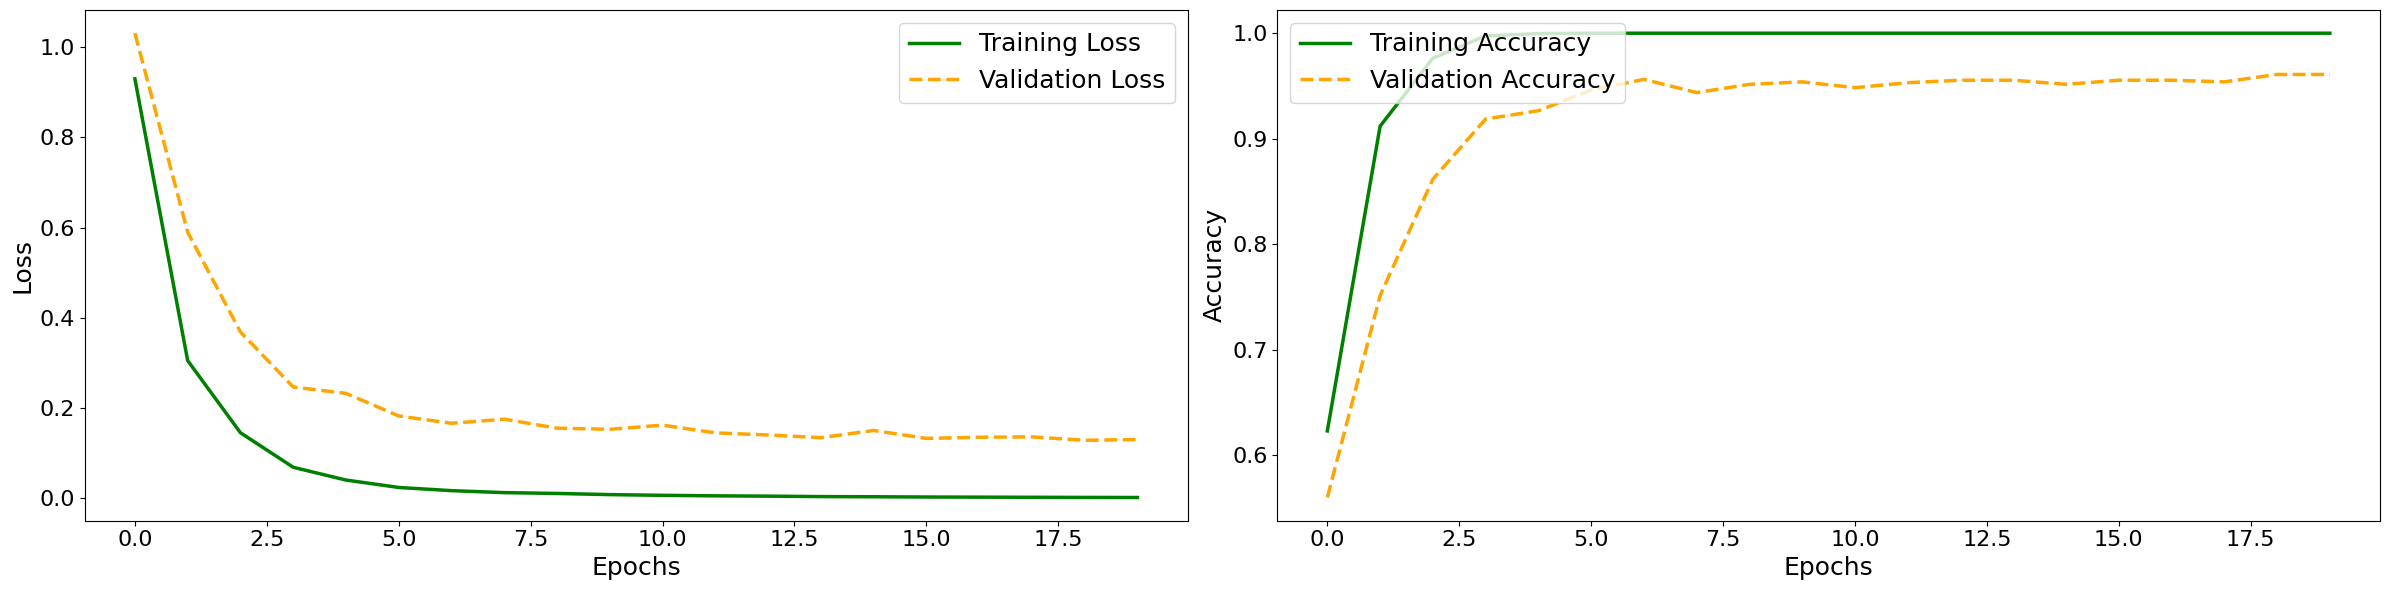

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_resnet50_fine_tune.pkl'
history = load_pickle_s3(bucket_name, s3_file_name, dbutils)

visualize_training(history)

Clearly, we can see that we unfreezing additional layers in the ResNet50 model, performance increases dramatically. Performance is not only more stable that the original ResNet50 model and the custom CNN in the previous notebook, but plateaus at a higher overall accuracy. Next, we will see if we can maintain that accuracy when simplifying the model through pruning.

Prune model

In [0]:
# Load fine-tuned model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50_fine_tune.h5'
pre_pruned_model = load_model_s3(bucket_name, s3_file_path, dbutils)

results = []
pruning_factors = np.arange(0, 1, 0.05)
for factor in pruning_factors:
    
    # Prune and re-compile model
    pruned_model = global_prune_model(pre_pruned_model, pruning_factor=factor)
    pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    test_loss, test_accuracy = pruned_model.evaluate(test_data, test_lab_cat, batch_size=32)

    # Calculate the number of parameters in the pruned model
    total_params = np.sum([np.count_nonzero(layer.get_weights()[0]) for layer in pruned_model.layers if len(layer.get_weights()) > 0])

    # Save results
    results.append({
        'pruning_factor': factor,
        'total_params': total_params,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss
    })
    
for result in results:
    print(f"Pruning Factor: {result['pruning_factor']}")
    print(f"Test Accuracy: {result['test_accuracy']}")
    print(f"Test Loss: {result['test_loss']}")
    print(f"Total Parameters: {result['total_params']}")
    print("\n")

Pruning completed. The bottom 0.0% of weights have been removed.
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9617 - loss: 0.1397
Pruning completed. The bottom 5.0% of weights have been removed.
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9528 - loss: 0.1463
Pruning completed. The bottom 10.0% of weights have been removed.
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9423 - loss: 0.1957
Pruning completed. The bottom 15.000000000000002% of weights have been removed.
17/40 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8169 - loss: 0.4842

*** WARNING: max output size exceeded, skipping output. ***

40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4778 - loss: 1.3863
Pruning completed. The bottom 60.00000000000001% of weights have been removed.
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4778 - loss: 1.3863
Pruning completed. The bottom 65.0% of weights have been removed.
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4778

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
# Save model and results
cwd = os.getcwd()
results_dir = os.path.join(os.path.dirname(cwd), 'results')

pruning_results_file = os.path.join(results_dir, 'results_pruning.pkl')
with open(pruning_results_file, 'wb') as f:
    pickle.dump(results, f)
clear_output(wait=False)

print(f"Pruning results saved as: {pruning_results_file}")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:706)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:508)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:613)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:636)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:295)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:

# # Convert predictions to class labels
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize

# # Binarize the true labels for ROC curve
# num_classes = len(np.unique(test_lab))
# true_labels_bin = label_binarize(test_lab, classes=[i for i in range(num_classes)])

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pruned_model.predict(test_data)[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curve for each class on four subplots in a 1 x 4 format
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# for i in range(num_classes):
#     ax = axes[i]
#     ax.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
#     ax.plot([0, 1], [0, 1], 'k--')
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.set_title(f'ROC Curve for Class {i}')
#     ax.legend(loc='lower right')
# plt.tight_layout()
# plt.show()